In [ ]:
!pip install tensorflow scikit-learn yfinance matplotlib pandas numpy

[*********************100%***********************]  1 of 1 completed

Epoch 1/80



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - loss: 0.0300 - val_loss: 0.0030
Epoch 2/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 4/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 6/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 7/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 9/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 10/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 11/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 12/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/ste

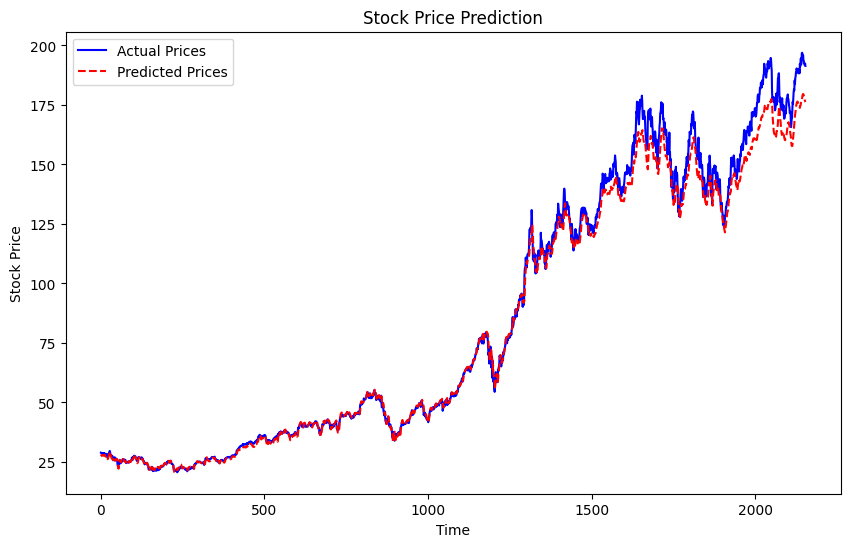

F1 Score: 0.5285


In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import yfinance as yf

# Fetch stock data

def get_stock_data(ticker, start='2015-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end)
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Return'] = df['Close'].pct_change()
    df = df[['Close', 'MA10', 'MA50', 'Return']].dropna()
    return df

# Preprocessing function

def preprocess_data(df, time_steps=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i])
        y.append(scaled_data[i, 0])  # Target is Close price
    return np.array(X), np.array(y), scaler, df

# Build LSTM model

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),
        LSTM(128, return_sequences=False),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mean_squared_error')
    return model

# Plot actual vs predicted prices

def plot_predictions(actual, predicted):
    if actual is None or predicted is None:
        print("Error: actual or predicted data is None.")
        return
    if len(actual) == 0 or len(predicted) == 0:
        print("Error: actual or predicted data is empty.")
        return

    print(f"Actual prices length: {len(actual)}")
    print(f"Predicted prices length: {len(predicted)}")
    print(f"First 5 Actual Prices: {actual[:5]}")
    print(f"First 5 Predicted Prices: {predicted[:5]}")

    plt.figure(figsize=(10,6))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predicted, color='red', linestyle='dashed', label='Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title('Stock Price Prediction')
    plt.show(block=True)

# Main function to train and predict

def train_and_predict(ticker='AAPL'):
    df = get_stock_data(ticker)
    time_steps = 60
    X, y, scaler, df_original = preprocess_data(df, time_steps)
    model = build_lstm_model((X.shape[1], X.shape[2]))

    model.fit(X, y, epochs=80, batch_size=32, validation_split=0.2, verbose=1)

    # Predict on last sequence
    last_seq = X[-1].reshape(1, time_steps, X.shape[2])
    predicted_price = model.predict(last_seq)
    predicted_price = scaler.inverse_transform(
        np.concatenate((predicted_price, np.zeros((1, df.shape[1]-1))), axis=1)
    )[:, 0]

    print(f'Predicted Price for next day: {predicted_price[0]}')

    if len(df_original) <= time_steps:
        print("Error: Not enough data points to plot actual vs predicted prices.")
        return model, scaler, None, None

    y_pred_scaled = model.predict(X)
    y_pred_unscaled = scaler.inverse_transform(
        np.concatenate((y_pred_scaled, np.zeros((y_pred_scaled.shape[0], df.shape[1]-1))), axis=1)
    )[:, 0]

    actual_prices = df_original['Close'].values[time_steps:]
    predicted_prices = y_pred_unscaled

    plot_predictions(actual_prices, predicted_prices)

    return model, scaler, actual_prices, predicted_prices

# Run the prediction
if __name__ == "__main__":
    model, scaler, actual_prices, predicted_prices = train_and_predict('AAPL')

    if actual_prices is not None and predicted_prices is not None:
        actual_classes = (actual_prices[1:] > actual_prices[:-1]).astype(int)
        predicted_classes = (predicted_prices[1:] > predicted_prices[:-1]).astype(int)
        f1 = f1_score(actual_classes, predicted_classes)
        print(f"F1 Score: {f1:.4f}")


In [22]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [17]:
# Fetch and engineer data
def get_stock_data(ticker='AAPL', start='2015-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end)
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df[['Close', 'MA10', 'MA50', 'Return']]


In [18]:
# Prepare data for LSTM
def preprocess_data(df, time_steps=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i])
        y.append(scaled_data[i, 0])  # Predicting Close price
    return np.array(X), np.array(y), scaler, df

In [19]:
# Build model
def build_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.0003), loss='mean_squared_error')
    return model


In [20]:
# Plot results
def plot_predictions(actual, predicted):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predicted, label='Predicted', color='red', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.show()


In [24]:
# Main training and prediction pipeline
def train_and_predict(ticker='AAPL'):
    df = get_stock_data(ticker)
    X, y, scaler, df_processed = preprocess_data(df)
    model = build_model((X.shape[1], X.shape[2]))

    model.fit(X, y, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

    y_pred_scaled = model.predict(X)
    y_pred = scaler.inverse_transform(
        np.hstack((y_pred_scaled, np.zeros((y_pred_scaled.shape[0], df.shape[1] - 1))))
    )[:, 0]

    actual = df_processed['Close'].values[60:]

    plot_predictions(actual, y_pred)

    actual_classes = (actual[1:] > actual[:-1]).astype(int)
    predicted_classes = (y_pred[1:] > y_pred[:-1]).astype(int)
    score = f1_score(actual_classes, predicted_classes)
    print(f"F1 Score: {score:.4f}")

    print(f"\nPredicted closing price for the last day in data: {y_pred[-1]:.2f}")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 0.0201 - val_loss: 0.0074
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0019 - val_loss: 0.0081
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0018 - val_loss: 0.0107
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.0017 - val_loss: 0.0082
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms

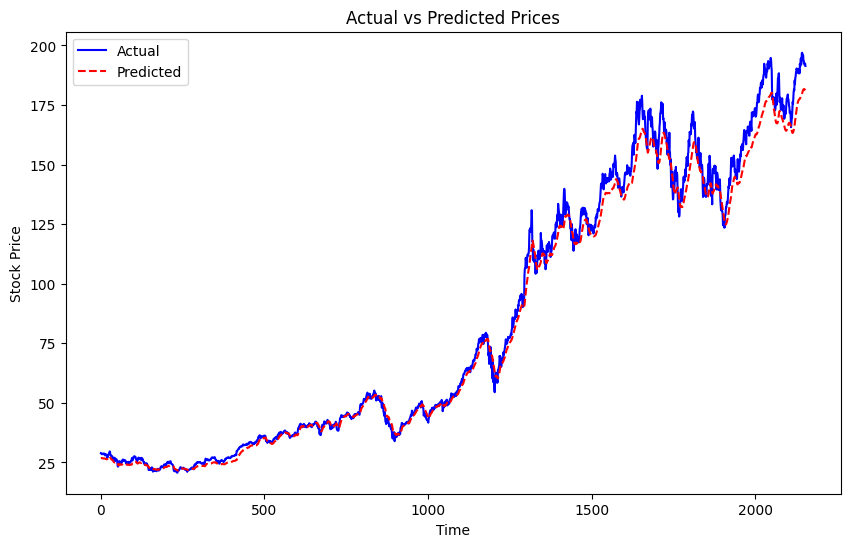

F1 Score: 0.5714

Predicted closing price for the last day in data: 181.16


In [25]:
# Execute
if __name__ == "__main__":
    train_and_predict('AAPL')